In [1]:
import os, sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
sc=spark.SparkContext()
sql=spark.SQLContext(sc)

In [2]:
os.chdir("/home/fvalle/phd/TWO-NN/")
from TwoNN import twonn_dimension

In [3]:
os.chdir("/home/fvalle/phd/master_thesis/gtex/")

In [4]:
genes = sql.read.option("header",'true').csv('/home/fvalle/phd/master_thesis/genes.txt')
genes.registerTempTable("genes")
genes.select("type_of_gene").distinct().show()
pc = sql.sql("SELECT * FROM genes WHERE type_of_gene='protein-coding'")

+--------------+
|  type_of_gene|
+--------------+
|          rRNA|
|         ncRNA|
|       unknown|
|         scRNA|
|      microRNA|
|         snRNA|
|     antisense|
|        snoRNA|
|        pseudo|
|protein-coding|
|    intergenic|
+--------------+



In [5]:
pc_list=pd.read_csv("http://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel().astype(str)

In [6]:
df = sql.read.option("header",True).option("delimiter",'\t').csv("/home/fvalle/phd/master_thesis/gtex/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_reads.gct")
df = df.withColumn('ensg',udf(lambda x: x[:15], StringType())(col('Name')))
df = df.withColumn('type',udf(lambda x: 'pc' if x in pc_list else 'nc', StringType())(col('ensg')))
df.registerTempTable("df")
df = sql.sql("SELECT * FROM df WHERE type='pc'")

In [7]:
df_files = pd.read_csv("/home/fvalle/phd/master_thesis/gtex/files.dat.ok", index_col=0)

In [8]:
tissues = df_files.groupby('primary_site').count().sort_values('secondary_site', ascending=False).index

In [9]:
model=PCA()

In [ ]:
selected = []
expl_var = {}
twonn_dims = []
N=100
for i in np.arange(1,len(tissues)-1,1,dtype=int):
    print(i)
    selected=np.concatenate((selected, df_files[df_files['primary_site']==tissues[i]][:N].index.values))
    np.random.shuffle(selected)
    data=df.select(list(selected)).toPandas().transpose().astype(float).values
    model.fit(data)
    expl_var[i]=model.explained_variance_
    twonn_dims.append(twonn_dimension(data))

1
2
3
4
5
6
7
8


In [ ]:
try:
    pd.DataFrame(data=expl_var).to_csv("intr_dim.csv")
except:
    pass
try:
    pd.DataFrame(data=twonn_dims).to_csv("twonn.csv")
except:
    pass

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

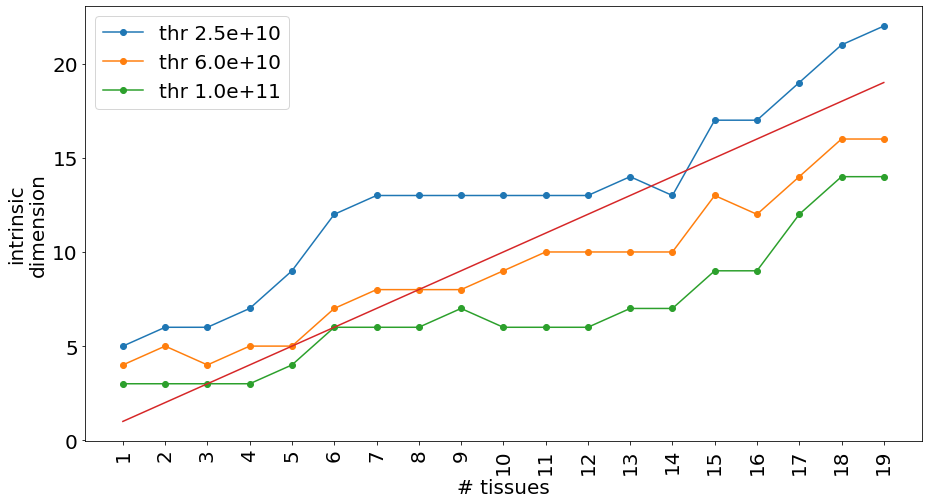

In [87]:
x=np.array([i for i in expl_var.keys()])
parab = lambda x,a,b,c: a+ b*x+c*x*x
fig=plt.figure(figsize=(15,8))
for thr in [2.5e10,6e10,1e11]:
    plot_data=[]
    for k in expl_var.keys():
        var=np.array(expl_var[k])
        plot_data.append(len(var[var>thr]))
    #par, pot = curve_fit(parab, x,plot_data)
    #plt.plot(x, parab(x, *par), ls=':', lw=2, label="%d+%.2f x%.3f xx"%(par[0],par[1],par[2]))
    plt.plot(x,plot_data, marker='o', label="thr %.1e"%thr)
plt.xlabel('# tissues', fontsize=20)
plt.ylabel('intrinsic\ndimension', fontsize=20)
plt.plot(x,x)
#plt.plot(x,1.06*x+2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
n_tissues=np.array([n for n in expl_var.keys()])
plt.xticks(ticks=n_tissues, labels=n_tissues, rotation=90)
plt.show()
fig.savefig("intrinsic_dimension.pdf")

In [63]:
pd.DataFrame(data=expl_var).to_csv("intrdim.csv",index=False, header=True)

In [ ]:
df_ev=pd.read_csv("intrdim.csv",  header=0)
df_ev.columns=df_ev.columns.astype(int)
expl_var=df_ev.to_dict('list')

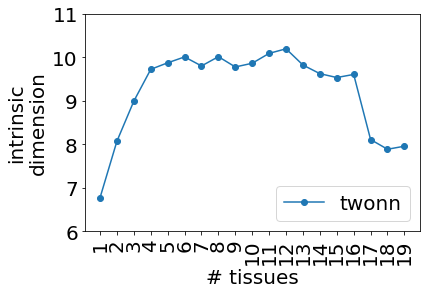

In [91]:
fig=plt.figure()
plt.plot(twonn_dims, marker='o', label='twonn')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('# tissues', fontsize=20)
plt.ylabel('intrinsic\ndimension', fontsize=20)
plt.ylim(6,11)
n_tissues=np.array([n for n in expl_var.keys()])
plt.xticks(ticks=n_tissues-1, labels=n_tissues, rotation=90)
plt.show()
fig.savefig("intrinsic_dimension_twonn.pdf")